In [72]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [101]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [110]:
# 1. 데이터 로딩 및 전처리
url = "https://raw.githubusercontent.com/Yana-one/AI_class/refs/heads/main/week6/diabetes.csv"
data = pd.read_csv(url)
print("✅ 데이터 로딩 완료")
data

✅ 데이터 로딩 완료


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


<Axes: ylabel='count'>

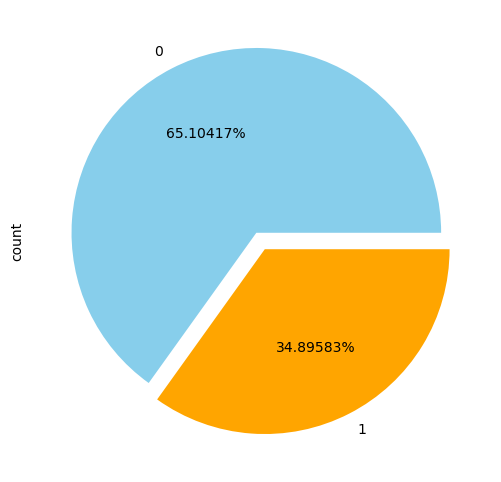

In [112]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
data.Outcome.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['skyblue', 'orange'], explode=(0.05, 0.05))

In [114]:
data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [116]:
# 데이터와 타겟 분리
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

In [118]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [120]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [122]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

In [124]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [126]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

## 모델 정의

In [129]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()


## 손실 함수 및 최적화 기법 정의

In [132]:
criterion = nn.BCEWithLogitsLoss()
# CrossEntropyLoss 다중 분류
optimizer = optim.Adam(model.parameters(), lr=0.001)

## 모델 학습

In [146]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float()) # labels에 unsqueeze(1) 적용 및 float형으로 변환

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)

            # [이진 분류용] sigmoid + 0.5 기준
            predicted = (torch.sigmoid(outputs) >= 0.5).float()

            total += labels.size(0)
            correct += (predicted == labels.unsqueeze(1).float()).sum().item() # labels에도 unsqueeze(1) 적용 및 float형으로 변환

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6540, Accuracy: 71.43%
Epoch 2/20, Loss: 0.6039, Accuracy: 77.27%
Epoch 3/20, Loss: 0.5598, Accuracy: 81.82%
Epoch 4/20, Loss: 0.5070, Accuracy: 82.47%
Epoch 5/20, Loss: 0.4974, Accuracy: 83.12%
Epoch 6/20, Loss: 0.4807, Accuracy: 82.47%
Epoch 7/20, Loss: 0.4717, Accuracy: 82.47%
Epoch 8/20, Loss: 0.4717, Accuracy: 81.17%
Epoch 9/20, Loss: 0.4794, Accuracy: 81.82%
Epoch 10/20, Loss: 0.4529, Accuracy: 81.17%
Epoch 11/20, Loss: 0.4617, Accuracy: 82.47%
Epoch 12/20, Loss: 0.4621, Accuracy: 81.82%
Epoch 13/20, Loss: 0.4505, Accuracy: 81.82%
Epoch 14/20, Loss: 0.4532, Accuracy: 81.17%
Epoch 15/20, Loss: 0.4469, Accuracy: 81.82%
Epoch 16/20, Loss: 0.4373, Accuracy: 82.47%
Epoch 17/20, Loss: 0.4333, Accuracy: 81.82%
Epoch 18/20, Loss: 0.4339, Accuracy: 81.82%
Epoch 19/20, Loss: 0.4530, Accuracy: 81.82%
Epoch 20/20, Loss: 0.4443, Accuracy: 82.47%
Training complete.


## 모델 평가

In [149]:
# 모델 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
model.eval()

# 실제 라벨과 예측값 저장용 리스트
all_labels = []
all_predictions = []

# 평가 시에는 그래디언트 계산 불필요 → torch.no_grad()로 메모리/속도 최적화
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)  # 순전파 수행
        _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 클래스 선택
        all_labels.extend(labels.cpu().numpy())       # 실제 정답 저장
        all_predictions.extend(predicted.cpu().numpy())  # 예측 결과 저장

# 리스트를 numpy 배열로 변환 (scikit-learn 사용을 위함)
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 평가 지표 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)  # 혼동 행렬
f1 = f1_score(all_labels, all_predictions, average='weighted')  # F1 점수 (클래스 불균형 고려)
precision = precision_score(all_labels, all_predictions, average='weighted')  # 정밀도
recall = recall_score(all_labels, all_predictions, average='weighted')  # 재현율

# 클래스별 Specificity 계산
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])  # True Negative
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]  # False Positive
    specificity.append(tn / (tn + fp))  # Specificity = TN / (TN + FP)

# 결과 출력
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')  # 평균 Specificity 출력

Confusion Matrix:
[[107   0]
 [ 47   0]]
F1 Score: 0.57
Precision: 0.48
Recall: 0.69
Specificity: 0.50


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


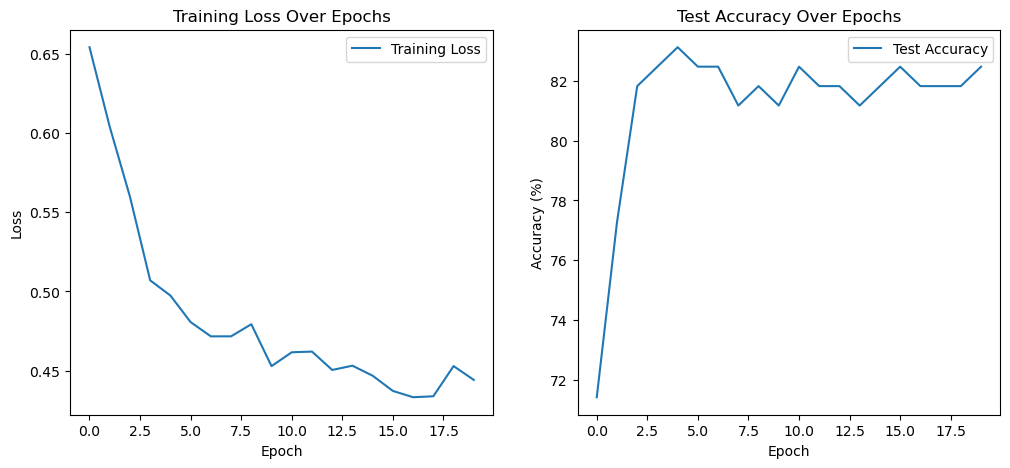

In [151]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()